# Project 1: Email Classifier
## Authors: Nigel Nelson, Collin Quinn
## Course: CS4981/031
---
### Imports:


In [1]:
import json
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## Part 1: Loading The Data:

In [2]:
email_dicts = []
json_dir_name = './email_json_dataset1'
json_pattern = os.path.join(json_dir_name, '*.json')
file_list = glob.glob(json_pattern)
for file in file_list:
    with open(file) as json_file:
        dict_data = json.load(json_file)
        email_dicts.append(dict_data)

In [3]:
email_df = pd.DataFrame.from_dict(email_dicts)
email_df['label'] = email_df['label'].astype('category')
email_df.head()

,label,to_address,from_address,subject,body
0,spam,<manager@flax9.uwaterloo.ca>,"""Barry Earl"" <Langmuir'sascetic@lobbyist.com>",Some useful advices for your health,\n\n\n\n\n\n\n\nDear customer.\nWanna know how...
1,spam,smile@speedy.uwaterloo.ca,%CUST_WORD %MID_WORD <FlorieTaft0887@yahoo.com>,$oftware taking a bite out of your budget? Try...,\n\n\n\n\n\n\n\n\n\n\n\n\nLove works a differe...
2,ham,Perl 6 announce list <perl6-announce@perl.org>,Ann Barcomb <kudra@domaintje.com>,Weekly Perl 6 mailing list summary for 08-14 A...,
3,ham,samba-cvs@samba.org,jerry@samba.org,svn commit: samba r22510 - in branches/SAMBA_3...,Author: jerry\nDate: 2007-04-25 09:36:47 +0000...
4,spam,theorize@plg.uwaterloo.ca,"""Eli Kirby"" <Ethansulfursalesgirl@iscs.co.kr>",evil,Finding rates low enough to suit is never an e...


In [4]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   label         63542 non-null  category
 1   to_address    63141 non-null  object  
 2   from_address  63542 non-null  object  
 3   subject       63410 non-null  object  
 4   body          63542 non-null  object  
dtypes: category(1), object(4)
memory usage: 2.0+ MB


#### Evaluate the class imbalance:

In [5]:
email_df['label'].value_counts()

spam    40450
ham     23092
Name: label, dtype: int64

## Part 2: Extracting Features

In [6]:
def under_sample_df(df, column):
    """
    Takes the supplied DataFrame, applies under sampling according to the
    column name specified, and returns the under sampled DataFrame.
    """
    desired_count = df[column].value_counts().min()
    mask = df.groupby(column)[column].transform('size') >= desired_count
    df = pd.concat((df[mask].groupby(column).sample(n=desired_count), df[~mask]), ignore_index=True)
    return df

In [7]:
def get_train_test_df(df, column, pos_label, split):
    """
    Returns training and testing DataFrames whose proportional sizes correspond to
    'split', where each has an equal ratio of positive labels and negative labels.
    """
    pos_df = df[df[column] == pos_label]
    neg_df = df[df[column] != pos_label]

    pos_train_idxs = np.random.choice(pos_df.shape[0], replace = False, size = int(pos_df.shape[0] * split))
    pos_test_idxs = np.delete(np.arange(0, pos_df.shape[0]), pos_train_idxs)
    neg_train_idxs = np.random.choice(neg_df.shape[0], replace = False, size = int(neg_df.shape[0] * split))
    neg_test_idxs = np.delete(np.arange(0, neg_df.shape[0]), neg_train_idxs)
    
    train_df = pos_df.iloc[pos_train_idxs]
    test_df = pos_df.iloc[pos_test_idxs]
    
    train_df = pd.concat([train_df, neg_df.iloc[neg_train_idxs]])
    test_df = pd.concat([test_df, neg_df.iloc[neg_test_idxs]])
    
    # Shuffle the rows of entries
    train_df = train_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    
    return train_df, test_df    

### Creating training and testing DataFrame Partitions:

In [8]:
train_df, test_df = get_train_test_df(email_df, 'label', 'spam', 0.8)

### Use *CountVectorizer* to create bag-of-words model:

In [9]:
vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df['body'])

In [10]:
print(f'Feature matrix # columns: {X_train.shape[1]}')
print(f'Feature matrix # rows: {X_train.shape[0]}')
print(f'Feature matrix # nonzero entries: {csr_matrix.count_nonzero(X_train)}\n')

Feature matrix # columns: 28278
Feature matrix # rows: 50833
Feature matrix # nonzero entries: 5088887



## Part 3: Creating & Evaluating Simple Classifier:

In [11]:
@ignore_warnings(category=ConvergenceWarning)
def eval_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates a supplied model on the supplied training and testing data.
    This evaluation prints the accuracy, recall, precision, and displays
    the resulting ROC curve.
    """
    model.fit(X_train , y_train)

    predictions = reg.predict(X_test)

    accuracy = accuracy_score(predictions, y_test)
    recall = recall_score(predictions, y_test, pos_label="spam")
    precision = precision_score(predictions, y_test, pos_label="spam")

    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label="spam")
    base_fpr = np.linspace(0, 1, 101)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    test_auc = auc(base_fpr, tpr)

    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)

    plt.plot(base_fpr,
             tpr,
             'b',
             label=f"Mean ROC (AUC ={test_auc})")

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

### Evaluating Logistic Regression model on unbalanced data:

Accuracy:  0.9687622944370131
Recall:  0.9558004502903188
Precision:  0.9970333745364648


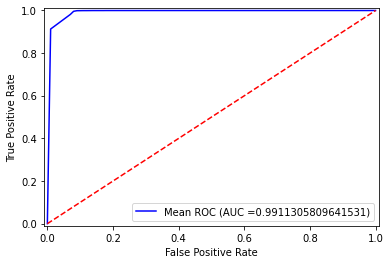

In [12]:
y_train = train_df['label'].to_numpy()

X_test = vectorizer.transform(test_df['body'])
y_test = test_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_test, y_test)

### Evaluating Logistic Regression model on weight-balanced data:

Accuracy:  0.9672672908962153
Recall:  0.9559173003802282
Precision:  0.9944375772558715


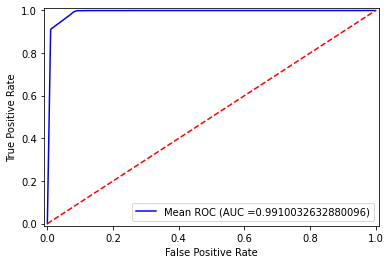

In [13]:
reg = LogisticRegression(max_iter=200, class_weight='balanced')
eval_model(reg, X_train, y_train, X_test, y_test)

### Evaluating Logistic Regression model on undersampled data:

Accuracy:  0.9574583243126218
Recall:  0.9280794165316045
Precision:  0.9917731110630007


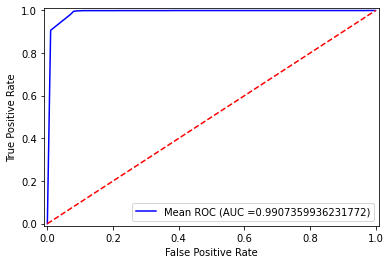

In [14]:
under_sampled_df = under_sample_df(email_df,'label')
train_df, test_df = get_train_test_df(under_sampled_df, 'label', 'spam', 0.8)

vectorizer = CountVectorizer(min_df=10)

X_train = vectorizer.fit_transform(train_df['body'])
y_train = train_df['label'].to_numpy()

X_test = vectorizer.transform(test_df['body'])
y_test = test_df['label'].to_numpy()

reg = LogisticRegression(max_iter=200)

eval_model(reg, X_train, y_train, X_test, y_test)